In [180]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import swing_technical_indicators
import numpy as np


# Replace with your Alpha Vantage API key
api_key = '89PMD611NPUTS89W'

# Function to fetch forex data
def fetch_forex_data(from_currency, to_currency):
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'FX_DAILY',
        'from_symbol': from_currency,
        'to_symbol': to_currency,
        'apikey': api_key,
        'outputsize': 'full'
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    # Extracting the time series data
    time_series = data.get('Time Series FX (Daily)', {})
    
    # Converting to DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    # Adding a column for the currency pair
    df['Currency Pair'] = f'{from_currency}/{to_currency}'
    
    # Filtering data for the last 10 years
    ten_years_ago = datetime.now() - timedelta(days=365*20)
    df = df[df.index >= ten_years_ago]
    
    return df

# List of common currency pairs to fetch which are allowed to trade in india 
currency_pairs = [
    ('USD', 'INR'), ('EUR', 'USD'), ('GBP', 'USD'), ('USD', 'JPY'), ('EUR', 'INR'),
    ('JPY', 'INR'), ('GBP', 'INR')
]

# Fetching data for all currency pairs and combining into a single DataFrame
all_data = pd.DataFrame()
for from_currency, to_currency in currency_pairs:
    forex_data = fetch_forex_data(from_currency, to_currency)
    all_data = pd.concat([all_data, forex_data])

# Resetting index for the combined DataFrame
all_data.reset_index(inplace=True)
all_data.rename(columns={'index': 'Date',"1. open":"Open_price","2. high":"Day_high","3. low":"Day_low","4. close":"Closing_price"}, inplace=True)

print(all_data)

            Date Open_price   Day_high    Day_low Closing_price Currency Pair
0     2014-11-07   61.39000   61.62000   61.34000      61.40000       USD/INR
1     2014-11-10   61.50000   61.63500   61.34000      61.49500       USD/INR
2     2014-11-11   61.53000   61.55500   61.50500      61.50800       USD/INR
3     2014-11-12   61.50800   61.56000   61.35000      61.39100       USD/INR
4     2014-11-13   61.36800   61.62300   61.35000      61.56500       USD/INR
...          ...        ...        ...        ...           ...           ...
18310 2024-11-21  106.69620  106.87660  106.21990     106.29930       GBP/INR
18311 2024-11-22  106.34520  106.38450  105.44460     105.74120       GBP/INR
18312 2024-11-25  106.27350  106.39990  105.62610     105.80810       GBP/INR
18313 2024-11-26  105.84890  106.23050  105.42730     105.87820       GBP/INR
18314 2024-11-27  105.96210  106.50110  105.92090     106.33210       GBP/INR

[18315 rows x 6 columns]


In [181]:
all_data.tail()

Date Open_price   Day_high    Day_low Closing_price Currency Pair
18310 2024-11-21  106.69620  106.87660  106.21990     106.29930       GBP/INR
18311 2024-11-22  106.34520  106.38450  105.44460     105.74120       GBP/INR
18312 2024-11-25  106.27350  106.39990  105.62610     105.80810       GBP/INR
18313 2024-11-26  105.84890  106.23050  105.42730     105.87820       GBP/INR
18314 2024-11-27  105.96210  106.50110  105.92090     106.33210       GBP/INR

In [182]:
usdinr = all_data.loc[all_data['Currency Pair']=='USD/INR']
usdinr.reset_index(drop=True,inplace=True)

In [184]:
usdinr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2623 non-null   datetime64[ns]
 1   Open_price     2623 non-null   object        
 2   Day_high       2623 non-null   object        
 3   Day_low        2623 non-null   object        
 4   Closing_price  2623 non-null   object        
 5   Currency Pair  2623 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 123.1+ KB


In [185]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

usdinr["Open_price"] = usdinr["Open_price"].astype(float)
usdinr["Day_high"] = usdinr["Day_high"].astype(float)
usdinr["Day_low"] = usdinr["Day_low"].astype(float)
usdinr["Closing_price"] = usdinr["Closing_price"].astype(float)

In [186]:
usdinr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2623 non-null   datetime64[ns]
 1   Open_price     2623 non-null   float64       
 2   Day_high       2623 non-null   float64       
 3   Day_low        2623 non-null   float64       
 4   Closing_price  2623 non-null   float64       
 5   Currency Pair  2623 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 123.1+ KB


Visualization of trend

In [187]:
import plotly.express as px

# Subset the relevant columns
a = usdinr[["Date", "Open_price", "Currency Pair"]]

# Get the single currency pair value
currency_pair = usdinr['Currency Pair'].iloc[0]  # Assumes all rows have the same value

# Plot using plotly.express.line
fig = px.line(a, x='Date', y='Open_price', 
              title=f'Open Price for last 10 years for the currency pair: {currency_pair}')

# Display the plot
fig.show()

AdFullerTest

In [188]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

for i in usdinr.columns : 
  if i!='Currency Pair' :
    print("ADFuller test for column : ",i)
    check_stationarity(usdinr[i])

ADFuller test for column :  Date
ADF Statistic: 0.607639
p-value: 0.987802
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Open_price
ADF Statistic: -0.718840
p-value: 0.841809
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_high
ADF Statistic: -0.722567
p-value: 0.840817
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test for column :  Day_low
ADF Statistic: -0.601546
p-value: 0.870632
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
Non-stationary
ADFuller test fo

Decomposition

In [89]:
# # Apply log transformation
# usdinr['Log_Open_price'] = np.log(usdinr['Open_price'])
# usdinr['Log_Day_high'] = np.log(usdinr['Day_high'])
# usdinr['Log_Day_low'] = np.log(usdinr['Day_low'])

# # Apply differencing
# usdinr['Open_price_diff'] = usdinr['Open_price'] - usdinr['Open_price'].shift(1)
# usdinr['Day_high_diff'] = usdinr['Day_high'] - usdinr['Day_high'].shift(1)
# usdinr['Day_low_diff'] = usdinr['Day_low'] - usdinr['Day_low'].shift(1)

# # Log transformation followed by differencing
# usdinr['Log_Open_price_diff'] = usdinr['Log_Open_price'] - usdinr['Log_Open_price'].shift(1)
# usdinr['Log_Day_high_diff'] = usdinr['Log_Day_high'] - usdinr['Log_Day_high'].shift(1)
# usdinr['Log_Day_low_diff'] = usdinr['Log_Day_low'] - usdinr['Log_Day_low'].shift(1)

# usdinr.head()

In [90]:
# usdinr.fillna(method='bfill', inplace=True)  # Backfill with the next value
# usdinr = usdinr.dropna()
# usdinr.head()

In [189]:
usdinr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2623 non-null   datetime64[ns]
 1   Open_price     2623 non-null   float64       
 2   Day_high       2623 non-null   float64       
 3   Day_low        2623 non-null   float64       
 4   Closing_price  2623 non-null   float64       
 5   Currency Pair  2623 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 123.1+ KB


In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_column(data, column, period=7):
    # Decompose the column
    decomposition = seasonal_decompose(data[column], model='additive', period=period, extrapolate_trend='freq')
    
    # Extract the residual component as deseasonalized data
    deseasonalized = data[column] - decomposition.seasonal
    
    return deseasonalized

# Identify non-stationary columns
non_stationary_columns = ['Day_high', 'Day_low', 'Open_price']

# Create deseasonalized columns
for col in non_stationary_columns:
    deseasonalized_col = deseasonalize_column(usdinr, col, period=7)  # Adjust the period as needed
    usdinr[f'Deseasonalized_{col}'] = deseasonalized_col


In [191]:
usdinr.head()

Date  Open_price  Day_high  Day_low  Closing_price Currency Pair  \
0 2014-11-07      61.390    61.620   61.340         61.400       USD/INR   
1 2014-11-10      61.500    61.635   61.340         61.495       USD/INR   
2 2014-11-11      61.530    61.555   61.505         61.508       USD/INR   
3 2014-11-12      61.508    61.560   61.350         61.391       USD/INR   
4 2014-11-13      61.368    61.623   61.350         61.565       USD/INR   

   Deseasonalized_Day_high  Deseasonalized_Day_low  Deseasonalized_Open_price  
0                61.610101               61.341917                  61.393506  
1                61.627339               61.332157                  61.493596  
2                61.547724               61.499491                  61.516284  
3                61.567341               61.356586                  61.504031  
4                61.633775               61.348468                  61.385332

EMA 50 Feature

In [192]:
usdinr['EMA_50'] = swing_technical_indicators.calculate_100ema(usdinr, 'Closing_price', 50)
usdinr['EMA_100'] = swing_technical_indicators.calculate_100ema(usdinr, 'Closing_price', 100)
usdinr['EMA_200'] = swing_technical_indicators.calculate_200ema(usdinr, 'Closing_price', 200)

In [193]:
usdinr.head()

Date  Open_price  Day_high  Day_low  Closing_price Currency Pair  \
0 2014-11-07      61.390    61.620   61.340         61.400       USD/INR   
1 2014-11-10      61.500    61.635   61.340         61.495       USD/INR   
2 2014-11-11      61.530    61.555   61.505         61.508       USD/INR   
3 2014-11-12      61.508    61.560   61.350         61.391       USD/INR   
4 2014-11-13      61.368    61.623   61.350         61.565       USD/INR   

   Deseasonalized_Day_high  Deseasonalized_Day_low  Deseasonalized_Open_price  \
0                61.610101               61.341917                  61.393506   
1                61.627339               61.332157                  61.493596   
2                61.547724               61.499491                  61.516284   
3                61.567341               61.356586                  61.504031   
4                61.633775               61.348468                  61.385332   

      EMA_50    EMA_100    EMA_200  
0  61.400000  61.400000  61.400000  
1  61.403725  61.401881  61.400945  
2  61.407815  61.403983  61.402010  
3  61.407155  61.403725  61.401901  
4  61.413345  61.406919  61.403524

In [194]:
usdinr['RSI'] = swing_technical_indicators.calculate_rsi(usdinr,'Closing_price',21)
usdinr_macd = swing_technical_indicators.calculate_macd(usdinr, column_name='Closing_price', short_period=12, long_period=26, signal_period=9)

for i in usdinr_macd.columns:

    usdinr[f"{i}"] = usdinr_macd[f'{i}']

bollinger_data = swing_technical_indicators.calculate_bollinger_bands(usdinr['Closing_price'])
usdinr = usdinr.join(bollinger_data)
usdinr.drop('Price',axis=1, inplace=True)

usdinr.head()

Date  Open_price  Day_high  Day_low  Closing_price Currency Pair  \
0 2014-11-07      61.390    61.620   61.340         61.400       USD/INR   
1 2014-11-10      61.500    61.635   61.340         61.495       USD/INR   
2 2014-11-11      61.530    61.555   61.505         61.508       USD/INR   
3 2014-11-12      61.508    61.560   61.350         61.391       USD/INR   
4 2014-11-13      61.368    61.623   61.350         61.565       USD/INR   

   Deseasonalized_Day_high  Deseasonalized_Day_low  Deseasonalized_Open_price  \
0                61.610101               61.341917                  61.393506   
1                61.627339               61.332157                  61.493596   
2                61.547724               61.499491                  61.516284   
3                61.567341               61.356586                  61.504031   
4                61.633775               61.348468                  61.385332   

      EMA_50    EMA_100    EMA_200  RSI      MACD  Signal_Line  \
0  61.400000  61.400000  61.400000  0.0  0.000000     0.000000   
1  61.403725  61.401881  61.400945  0.0  0.007578     0.001516   
2  61.407815  61.403983  61.402010  0.0  0.014466     0.004106   
3  61.407155  61.403725  61.401901  0.0  0.010365     0.005358   
4  61.413345  61.406919  61.403524  0.0  0.020914     0.008469   

   MACD_Histogram      SMA  Upper Band  Lower Band  
0        0.000000  61.7496   62.164424   61.334776  
1        0.006063  61.7496   62.164424   61.334776  
2        0.010361  61.7496   62.164424   61.334776  
3        0.005007  61.7496   62.164424   61.334776  
4        0.012445  61.7496   62.164424   61.334776

In [195]:
X = usdinr.drop(['Date','Open_price','Day_high','Day_low','Closing_price','Currency Pair'],axis=1)
y =usdinr['Closing_price']

In [196]:
columns = X.columns
print(columns)
X.head()

Index(['Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_50', 'EMA_100', 'EMA_200', 'RSI',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band',
       'Lower Band'],
      dtype='object')


Deseasonalized_Day_high  Deseasonalized_Day_low  Deseasonalized_Open_price  \
0                61.610101               61.341917                  61.393506   
1                61.627339               61.332157                  61.493596   
2                61.547724               61.499491                  61.516284   
3                61.567341               61.356586                  61.504031   
4                61.633775               61.348468                  61.385332   

      EMA_50    EMA_100    EMA_200  RSI      MACD  Signal_Line  \
0  61.400000  61.400000  61.400000  0.0  0.000000     0.000000   
1  61.403725  61.401881  61.400945  0.0  0.007578     0.001516   
2  61.407815  61.403983  61.402010  0.0  0.014466     0.004106   
3  61.407155  61.403725  61.401901  0.0  0.010365     0.005358   
4  61.413345  61.406919  61.403524  0.0  0.020914     0.008469   

   MACD_Histogram      SMA  Upper Band  Lower Band  
0        0.000000  61.7496   62.164424   61.334776  
1        0.006063  61.7496   62.164424   61.334776  
2        0.010361  61.7496   62.164424   61.334776  
3        0.005007  61.7496   62.164424   61.334776  
4        0.012445  61.7496   62.164424   61.334776

In [197]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X,columns = columns)

In [198]:
X.head()

Deseasonalized_Day_high  Deseasonalized_Day_low  Deseasonalized_Open_price  \
0                 0.002716                0.004312                   0.002460   
1                 0.003467                0.003890                   0.006787   
2                 0.000000                0.011124                   0.007768   
3                 0.000854                0.004946                   0.007238   
4                 0.003747                0.004596                   0.002107   

     EMA_50   EMA_100   EMA_200  RSI      MACD  Signal_Line  MACD_Histogram  \
0  0.000000  0.000000  0.000000  0.0  0.435743     0.428316        0.501290   
1  0.000164  0.000083  0.000042  0.0  0.440006     0.429330        0.511641   
2  0.000344  0.000177  0.000090  0.0  0.443880     0.431063        0.518980   
3  0.000315  0.000165  0.000085  0.0  0.441573     0.431901        0.509839   
4  0.000587  0.000307  0.000158  0.0  0.447507     0.433982        0.522539   

        SMA  Upper Band  Lower Band  
0  0.001107    0.000439    0.029708  
1  0.001107    0.000439    0.029708  
2  0.001107    0.000439    0.029708  
3  0.001107    0.000439    0.029708  
4  0.001107    0.000439    0.029708

Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

def random_forest_model_cv(X, y):
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor()
    
    # Define the cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold CV
    
    # Perform cross-validation
    mae_scores = -cross_val_score(rf, X, y, scoring='neg_mean_absolute_error', cv=cv)
    mape_scores = []
    r2_scores = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Predict
        y_pred = rf.predict(X_test)
        
        # Calculate metrics
        mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))

    # Average the metrics across folds
    mean_mae = np.mean(mae_scores)
    mean_mape = np.mean(mape_scores)
    mean_r2 = np.mean(r2_scores)

    # Print the results
    print(f"Cross-Validated Mean Absolute Error (MAE): {mean_mae}")
    print(f"Cross-Validated Mean Absolute Percentage Error (MAPE): {mean_mape * 100}%")
    print(f"Cross-Validated R-squared (R^2): {mean_r2}")

# Call the function with your data
random_forest_model_cv(X, y)


Cross-Validated Mean Absolute Error (MAE): 0.09619854863249647
Cross-Validated Mean Absolute Percentage Error (MAPE): 0.13446589970855294%
Cross-Validated R-squared (R^2): 0.9995991313994506


Training Mean Absolute Error : 0.034726578431373965
Test Mean Absolute Error : 0.1011282160101648
Training Mean Absolute Percentage Error (MAPE): 0.04862874537802563%
Test Mean Absolute Percentage Error (MAPE): 0.142028081974331%
Training R-squared (R^2): 0.9999481108308078
Test R-squared (R^2): 0.9995775256096624

Random Forest Metrics : {'MAE': np.float64(0.1011282160101648), 'MAPE': np.float64(0.142028081974331), 'R^2': 0.9995775256096624}


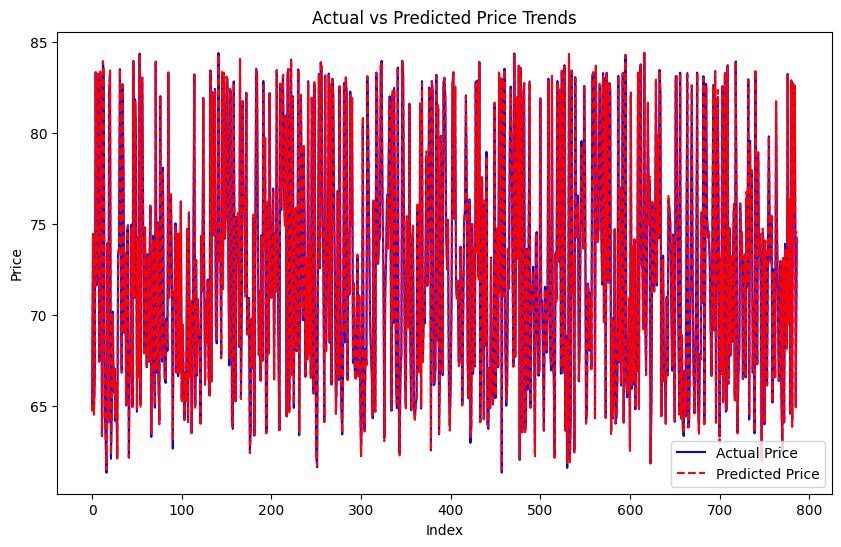

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def random_forest_model(X, y):
    rf = RandomForestRegressor()
    rf_metrics = {}

    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict and calculate metrics
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Evaluate the model on training and testing sets
    y_train_pred = rf.predict(X_train).flatten()
    y_test_pred = rf.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Training Mean Absolute Error : {train_mae}")
    print(f"Test Mean Absolute Error : {test_mae}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape * 100}%")
    print(f"Training R-squared (R^2): {train_r2}")
    print(f"Test R-squared (R^2): {test_r2}")

    rf_metrics = {'MAE': mae, 'MAPE': mape * 100, 'R^2': r2}
    print("\nRandom Forest Metrics :", rf_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Call the function
random_forest_model(X, y)

Selected Features: Index(['Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_100', 'Upper Band'],
      dtype='object')
Training Mean Absolute Error : 0.034385313725490724
Test Mean Absolute Error : 0.10045529351969493
Training Mean Absolute Percentage Error (MAPE): 0.04811419356223908%
Test Mean Absolute Percentage Error (MAPE): 0.14099972382068388%
Training R-squared (R^2): 0.9999484470525225
Test R-squared (R^2): 0.9995860717037751

Random Forest Metrics : {'MAE': np.float64(0.10045529351969493), 'MAPE': np.float64(0.14099972382068388), 'R^2': 0.9995860717037751}


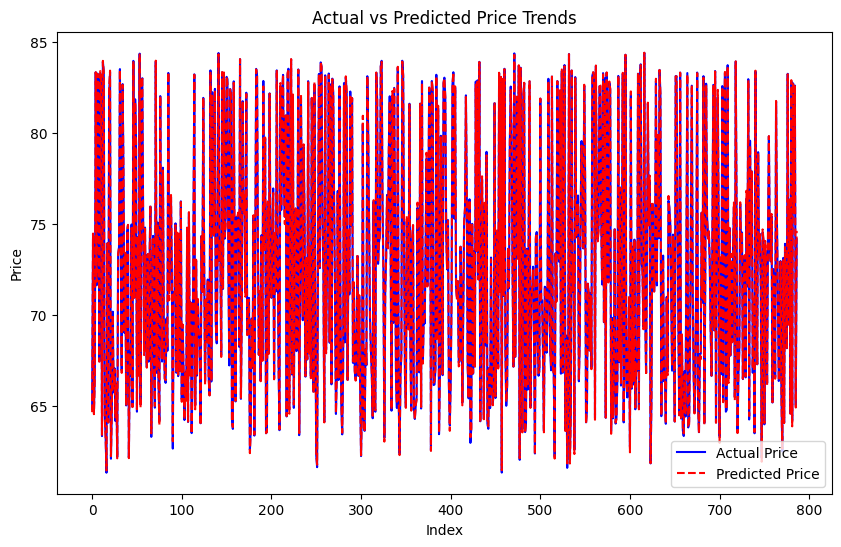

In [204]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
def feature_selection_with_rfe(X, y):
    rf = RandomForestRegressor(random_state=42)
    
    # Recursive Feature Elimination
    rfe = RFE(estimator=rf, n_features_to_select=5)  # Select the top 5 features
    rfe.fit(X, y)

    # Selected features
    selected_features = X.columns[rfe.support_]
    print("Selected Features:", selected_features)

    # Reduced Dataset
    X_selected = X[selected_features]
    return X_selected


# Perform feature selection
X_selected = feature_selection_with_rfe(X, y)

# Train the model on selected features
random_forest_model(X_selected, y)

Training Mean Absolute Error : 0.0351725408942216
Test Mean Absolute Error : 0.09910353240152432
Training Mean Absolute Percentage Error (MAPE): 0.0492614250000416%
Test Mean Absolute Percentage Error (MAPE): 0.1388019955229773%
Training R-squared (R^2): 0.9999463562150552
Test R-squared (R^2): 0.9995860291536859

Random Forest Metrics : {'MAE': np.float64(0.09910353240152432), 'MAPE': np.float64(0.1388019955229773), 'R^2': 0.9995860291536859}


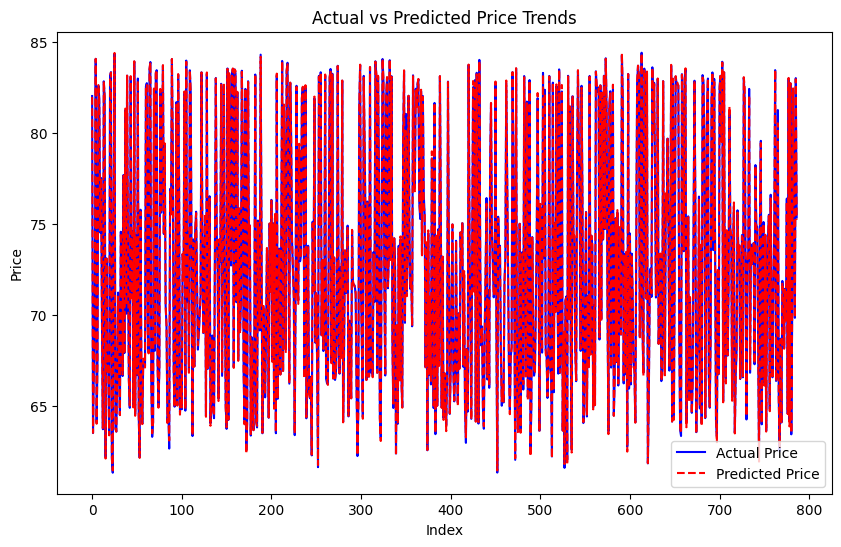

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def random_forest_model(X, y):
    rf = RandomForestRegressor()
    rf_metrics = {}

    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict and calculate metrics
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Evaluate the model on training and testing sets
    y_train_pred = rf.predict(X_train).flatten()
    y_test_pred = rf.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Training Mean Absolute Error : {train_mae}")
    print(f"Test Mean Absolute Error : {test_mae}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape * 100}%")
    print(f"Training R-squared (R^2): {train_r2}")
    print(f"Test R-squared (R^2): {test_r2}")

    rf_metrics = {'MAE': mae, 'MAPE': mape * 100, 'R^2': r2}
    print("\nRandom Forest Metrics :", rf_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Call the function
random_forest_model(X, y)


In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Define a function to create lagged features
def create_lagged_features(data, lag=7, forecast_horizon=7):
    """
    Creates lagged features and target variable for time-series forecasting.
    """
    for i in range(1, lag + 1):
        data[f'lag_{i}'] = data['y'].shift(i)
    # Target is the value at t + forecast_horizon
    data['target'] = data['y'].shift(-forecast_horizon)
    return data

# Random Forest Model Function
def random_forest_model(data, lag=7, forecast_horizon=7):
    # Step 1: Prepare lagged features and target
    data = create_lagged_features(data, lag, forecast_horizon).dropna()

    # Step 2: Define features (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, lag + 1)]]
    y = data['target']

    # Step 3: Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    # Step 4: Initialize and fit the model
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Step 5: Make predictions
    y_pred = rf.predict(X_test)

    # Step 6: Calculate metrics
    train_pred = rf.predict(X_train)
    mae_train = mean_absolute_error(y_train, train_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    mape_train = mean_absolute_percentage_error(y_train, train_pred) * 100
    mape_test = mean_absolute_percentage_error(y_test, y_pred) * 100

    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, y_pred)

    # Print results
    print(f"Training Mean Absolute Error (MAE): {mae_train}")
    print(f"Test Mean Absolute Error (MAE): {mae_test}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {mape_train}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {mape_test}%")
    print(f"Training R-squared (R^2): {r2_train}")
    print(f"Test R-squared (R^2): {r2_test}")

    # Return predictions and model metrics
    return {
        'model': rf,
        'train_metrics': {'MAE': mae_train, 'MAPE': mape_train, 'R^2': r2_train},
        'test_metrics': {'MAE': mae_test, 'MAPE': mape_test, 'R^2': r2_test},
        'predictions': y_pred
    }

# Run the model
results = random_forest_model(usdinr, lag=7, forecast_horizon=7)

Training Mean Absolute Error (MAE): 0.17555556304824416
Test Mean Absolute Error (MAE): 5.63368812899101
Training Mean Absolute Percentage Error (MAPE): 0.2543142569994906%
Test Mean Absolute Percentage Error (MAPE): 6.825575607300021%
Training R-squared (R^2): 0.9964813862603256
Test R-squared (R^2): -3.6375218082061203


SVM

Training Mean Absolute Error : 0.12228053251541837
Test Mean Absolute Error : 0.12743048380227562
Training Mean Absolute Percentage Error (MAPE): 0.16976198776650622%
Test Mean Absolute Percentage Error (MAPE): 0.1771708901207505%
Training R-squared (R^2): 0.99939304235228
Test R-squared (R^2): 0.9993058056499504

SVM Metrics : {}


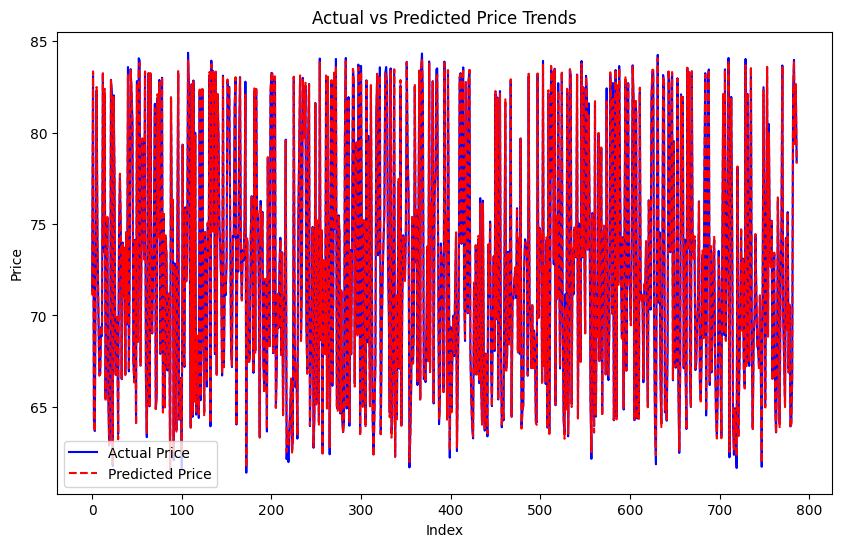

In [130]:
from sklearn.svm import SVR
# SVM Model
def svm_model(X,y):
    svm = SVR()
    svm_metrics = {}
        
    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
    
    # Train the model
    svm.fit(X_train, y_train)
    
    # Evaluate the model on training and testing sets
    y_train_pred = svm.predict(X_train).flatten()
    y_test_pred = svm.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Training Mean Absolute Error : {train_mae}")
    print(f"Test Mean Absolute Error : {test_mae}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape * 100}%")
    print(f"Training R-squared (R^2): {train_r2}")
    print(f"Test R-squared (R^2): {test_r2}")

    print("\nSVM Metrics :", svm_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


svm_model(X,y)

Gradient Boosting

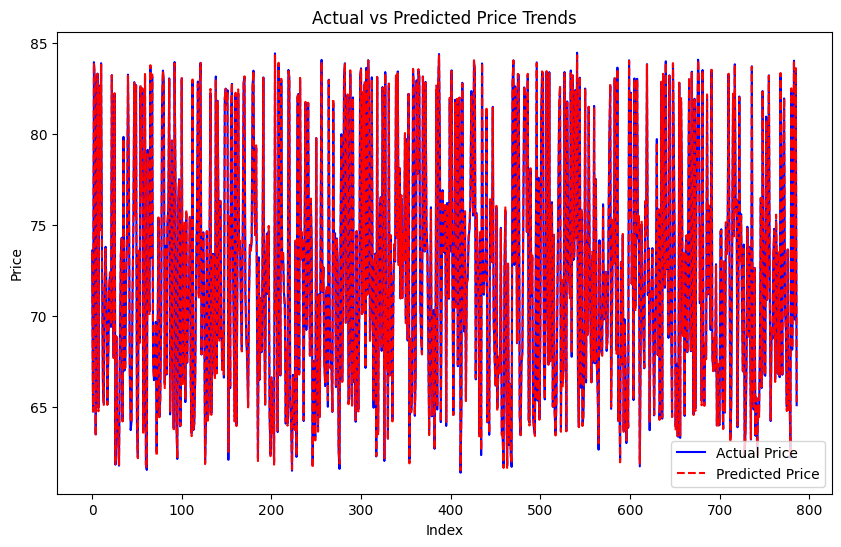

Train Mean Absolute Error: 0.06757044233742268
Test Mean Absolute Error: 0.10667518812908972
Train Mean Absolute Percentage Error (MAPE): 0.0945598822605283%
Test Mean Absolute Percentage Error (MAPE): 0.14997585262741606%
Train R-squared (R^2): 0.999828584593464
Test R-squared (R^2): 0.9995530197343079

Gradient Boosting Metrics  {'MACD_Histogram': {'MAE': np.float64(0.10667518812908972), 'MAPE': np.float64(0.14997585262741606), 'R^2': 0.9995530197343079}}


In [144]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

def gradient_boosting_model(X,y):
    
    gb = GradientBoostingRegressor()
    gb_metrics = {}

    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        
    # Train the model
    gb.fit(X_train, y_train)
    
    # Predict
    y_test_pred = gb.predict(X_test)
    y_train_pred = gb.predict(X_train)
    
    # Calculate metrics
    testmae = mean_absolute_error(y_test, y_test_pred)
    testmape = mean_absolute_percentage_error(y_test, y_test_pred)
    testr2 = r2_score(y_test, y_test_pred)

    trainmae = mean_absolute_error(y_train, y_train_pred)
    trainmape = mean_absolute_percentage_error(y_train, y_train_pred)
    trainr2 = r2_score(y_train, y_train_pred)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    print(f"Train Mean Absolute Error: {trainmae}")
    print(f"Test Mean Absolute Error: {testmae}")
    print(f"Train Mean Absolute Percentage Error (MAPE): {trainmape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {testmape * 100}%")
    print(f"Train R-squared (R^2): {trainr2}")
    print(f"Test R-squared (R^2): {testr2}")
    
    gb_metrics[i] = {'MAE': testmae, 'MAPE': testmape * 100, 'R^2': testr2}

    print("\nGradient Boosting Metrics ", gb_metrics)


gradient_boosting_model(X,y)

XGBoost

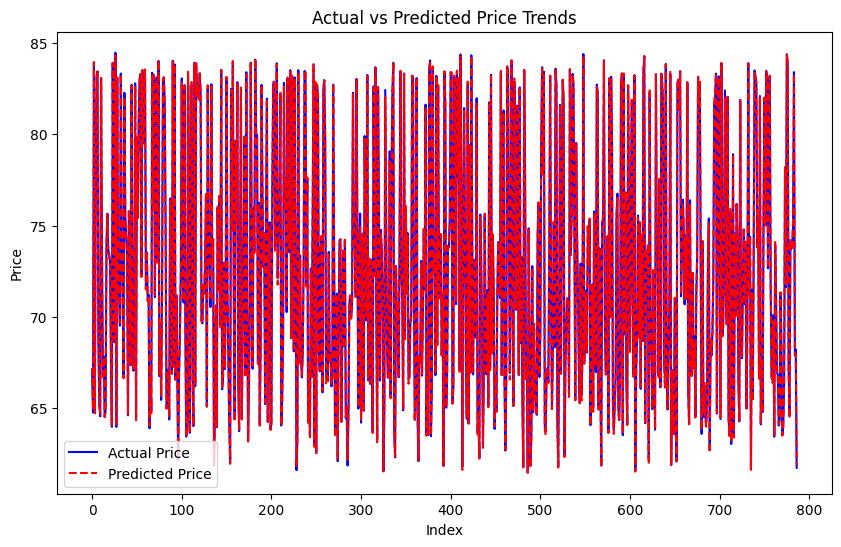

Train Mean Absolute Error: 0.043320960694025
Test Mean Absolute Error: 0.10089499119294473
Train Mean Absolute Percentage Error (MAPE): 0.0605825712198274%
Test Mean Absolute Percentage Error (MAPE): 0.14093057946225576%
Train R-squared (R^2): 0.9999332927593084
Test R-squared (R^2): 0.9995813492940675

XGBoost Metrics : {'MACD_Histogram': {'MAE': np.float64(0.10089499119294473), 'MAPE': np.float64(0.14093057946225576), 'R^2': 0.9995813492940675}}


In [146]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

def xgboost_model(X,y):
    # Split the data by currency pair
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
    xgb_metrics = {}
        
    # Prepare data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
        
    # Train the model
    xgb.fit(X_train, y_train)
    
    # Predict
    y_test_pred = xgb.predict(X_test)
    y_train_pred = xgb.predict(X_train)
    
    # Calculate metrics
    testmae = mean_absolute_error(y_test, y_test_pred)
    testmape = mean_absolute_percentage_error(y_test, y_test_pred)
    testr2 = r2_score(y_test, y_test_pred)

    trainmae = mean_absolute_error(y_train, y_train_pred)
    trainmape = mean_absolute_percentage_error(y_train, y_train_pred)
    trainr2 = r2_score(y_train, y_train_pred)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    
    print(f"Train Mean Absolute Error: {trainmae}")
    print(f"Test Mean Absolute Error: {testmae}")
    print(f"Train Mean Absolute Percentage Error (MAPE): {trainmape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {testmape * 100}%")
    print(f"Train R-squared (R^2): {trainr2}")
    print(f"Test R-squared (R^2): {testr2}")

    
    xgb_metrics[i] = {'MAE': testmae, 'MAPE': testmape * 100, 'R^2': testr2}

    print("\nXGBoost Metrics :", xgb_metrics)
    


xgboost_model(X,y)


DNN

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5194.9463 - mae: 71.7711 - val_loss: 4607.9707 - val_mae: 67.5728
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4218.0391 - mae: 64.4345 - val_loss: 2717.4182 - val_mae: 50.9272
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2122.0637 - mae: 43.2421 - val_loss: 1016.4442 - val_mae: 25.2670
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 956.4963 - mae: 25.7736 - val_loss: 820.0521 - val_mae: 24.0577
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 807.7079 - mae: 23.7319 - val_loss: 676.7885 - val_mae: 21.3068
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 713.4144 - mae: 22.1143 - val_loss: 552.1518 - val_mae: 19.1361
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 571.7393 - mae: 19.7287 - val_loss: 460.9273 - val_mae: 17.5951
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 485.7217 - mae: 18.0896 - val_loss: 398.4312 - val_mae: 16.0554
Epoch 9/10

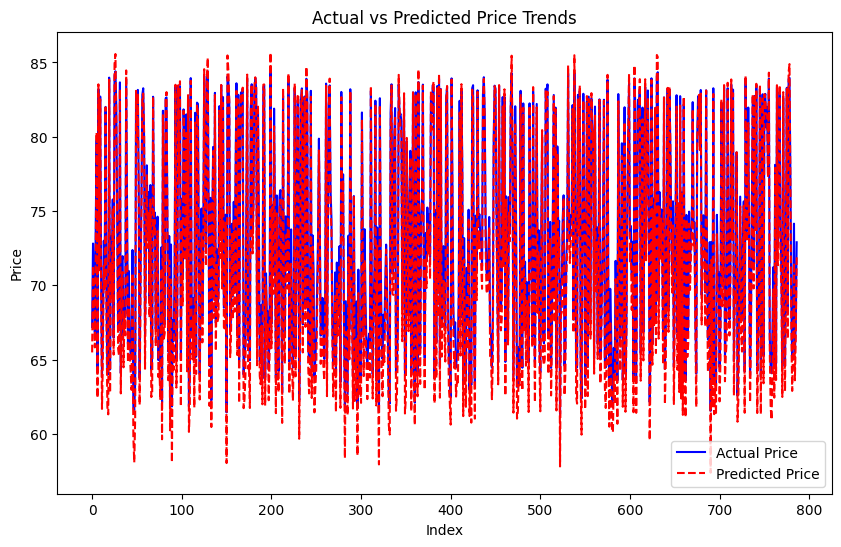

({'Train_MAE': np.float64(1.3098199833161701),
  'Test_MAE': np.float64(1.294236099549503),
  'Train_MAPE': np.float64(1.9065327799192684),
  'Test_MAPE': np.float64(1.8836483842195229),
  'Train_R^2': 0.9478457573931423,
  'Test_R^2': 0.95230176647546},
 <Sequential name=sequential_74, built=True>)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def deep_learning_model(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Normalize the features (helps in better training of neural networks)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    # Define the Deep Neural Network
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),  # Helps prevent overfitting
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # Use a portion of training data for validation
        epochs=100,  # Adjust epochs based on data size and complexity
        batch_size=32,
        verbose=1
    )

    # Evaluate the model on training and testing sets
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()

    # Calculate metrics for training data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Training Mean Absolute Error : {train_mae}")
    print(f"Test Mean Absolute Error : {test_mae}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape * 100}%")
    print(f"Training R-squared (R^2): {train_r2}")
    print(f"Test R-squared (R^2): {test_r2}")

    # Store metrics in a dictionary
    dnn_metrics = {
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape * 100,
        'Test_MAPE': test_mape * 100,
        'Train_R^2': train_r2,
        'Test_R^2': test_r2
    }

   # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return dnn_metrics, model  # Return the metrics and trained model

deep_learning_model(X,y)


In [140]:
def build_and_train_model(X_train, y_train, X_val, y_val, params):
    """
    Builds and trains a deep learning model based on the provided hyperparameters.
    """
    # Build the model
    model = Sequential([
        Dense(params['layer1_units'], activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(params['dropout_rate']),
        Dense(params['layer2_units'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0  # Suppress output for faster grid search
    )

    return model, history

def grid_search_deep_learning(X, y, param_grid):
    """
    Performs a grid search for hyperparameter tuning on a deep learning model.
    """
    # Split the data into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    # Normalize the features
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    best_params = None
    best_model = None
    best_score = float('inf')

    # Iterate over all combinations of hyperparameters
    for learning_rate in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            for layer1_units in param_grid['layer1_units']:
                for layer2_units in param_grid['layer2_units']:
                    for dropout_rate in param_grid['dropout_rate']:
                        for epochs in param_grid['epochs']:
                            # Set the hyperparameters
                            params = {
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'layer1_units': layer1_units,
                                'layer2_units': layer2_units,
                                'dropout_rate': dropout_rate,
                                'epochs': epochs
                            }
                            print(f"Training with params: {params}")

                            # Train the model
                            model, history = build_and_train_model(X_train, y_train, X_val, y_val, params)

                            # Evaluate on the validation set
                            y_val_pred = model.predict(X_val).flatten()
                            val_mae = mean_absolute_error(y_val, y_val_pred)

                            # Save the model if it performs better
                            if val_mae < best_score:
                                best_score = val_mae
                                best_params = params
                                best_model = model

                            print(f"Validation MAE: {val_mae}")

    print("\nBest Hyperparameters:", best_params)
    print("Best Validation MAE:", best_score)

    # Evaluate the best model on the test set
    y_test_pred = best_model.predict(X_test).flatten()
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print("\nTest MAE with Best Model:", test_mae)
    print("Test R² with Best Model:", test_r2)

    return best_model, best_params, best_score

# Example usage:
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'layer1_units': [64, 128],
    'layer2_units': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'epochs': [50, 100]
}

best_model, best_params, best_score = grid_search_deep_learning(X, y, param_grid)

Training with params: {'learning_rate': 0.001, 'batch_size': 32, 'layer1_units': 64, 'layer2_units': 32, 'dropout_rate': 0.2, 'epochs': 50}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation MAE: 1.1968515546003544
Training with params: {'learning_rate': 0.001, 'batch_size': 32, 'layer1_units': 64, 'layer2_units': 32, 'dropout_rate': 0.2, 'epochs': 100}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation MAE: 0.7736687119153931
Training with params: {'learning_rate': 0.001, 'batch_size': 32, 'layer1_units': 64, 'layer2_units': 32, 'dropout_rate': 0.3, 'epochs': 50}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Validation MAE: 1.7703806444381174
Training with params: {'learning_rate': 0.001, 'batch_size': 32, 'layer1_units': 64, 'layer2_units': 32, 'dropout_rate': 0.3, 'epochs': 100}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation MAE: 1.9488963807815427
Training with params: {'learning_rate': 0.001, 'batch_size': 32, 'layer1_units': 64, 'layer2_units': 64, 'dropout_rate': 0.2, 'epochs': 50}

In [141]:
best_params

{'learning_rate': 0.001,
 'batch_size': 32,
 'layer1_units': 128,
 'layer2_units': 64,
 'dropout_rate': 0.3,
 'epochs': 50}

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5079.0581 - mae: 70.9357 - val_loss: 3818.3989 - val_mae: 61.3874
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3126.3848 - mae: 54.2101 - val_loss: 810.5979 - val_mae: 23.0847
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 941.9933 - mae: 25.9647 - val_loss: 573.2716 - val_mae: 19.6738
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 668.8603 - mae: 21.2102 - val_loss: 412.6030 - val_mae: 16.3860
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 563.3768 - mae: 19.5912 - val_loss: 312.7907 - val_mae: 14.2631
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 466.5736 - mae: 17.6999 - val_loss: 251.7487 - val_mae: 12.7873
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 381.1921 - mae: 15.8945 - val_loss: 202.7033 - val_mae: 11.4368
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 338.9390 - mae: 15.1164 - val_loss: 155.1355 - val_mae: 9.9794
Epoch 9/50
46/46 ━━━━━

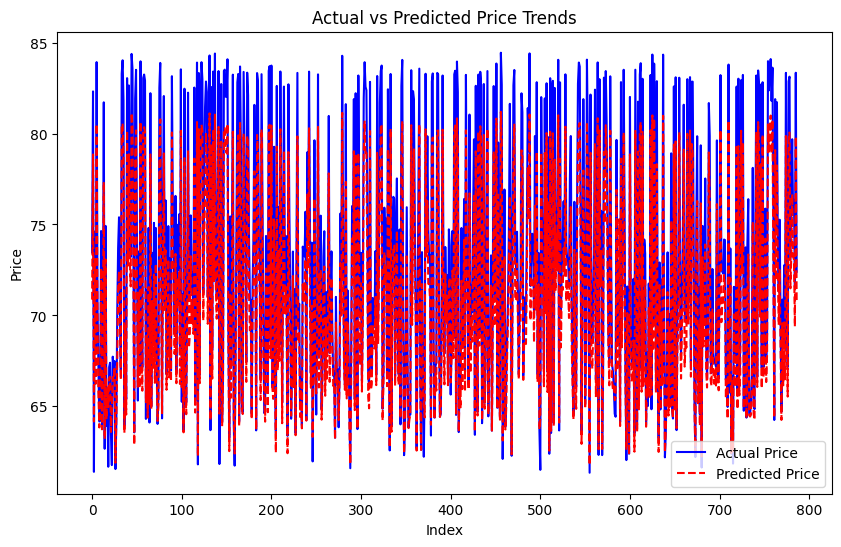

Training Mean Absolute Error : 1.805230909297348
Test Mean Absolute Error : 1.9098700421460553
Training Mean Absolute Percentage Error (MAPE): 2.3791925989548215%
Test Mean Absolute Percentage Error (MAPE): 2.5097164649405825%
Training R-squared (R^2): 0.8987903049328065
Test R-squared (R^2): 0.8933852232161426


In [ ]:
def deep_learning_model_with_best_params(X, y, best_params):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Split further to create a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    # Normalize the features (helps in better training of neural networks)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_val = (X_val - mean) / std
    X_test = (X_test - mean) / std

    # Define the Deep Neural Network with hyperparameters
    model = Sequential([
        Dense(best_params['layer1_units'], activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(best_params['dropout_rate']),  # Dropout layer to prevent overfitting
        Dense(best_params['layer2_units'], activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model with the specified learning rate and optimizer
    model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=best_params['epochs'],  # Epochs as per the grid search result
        batch_size=best_params['batch_size'],  # Batch size as per the grid search result
        verbose=1
    )

    # Evaluate the model on training and testing sets
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()

    # Calculate metrics for training and testing data
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_test_pred)), y_test_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Print the metrics
    print(f"Training Mean Absolute Error : {train_mae}")
    print(f"Test Mean Absolute Error : {test_mae}")
    print(f"Training Mean Absolute Percentage Error (MAPE): {train_mape * 100}%")
    print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape * 100}%")
    print(f"Training R-squared (R^2): {train_r2}")
    print(f"Test R-squared (R^2): {test_r2}")
    
    # Store metrics in a dictionary
    dnn_metrics = {
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_MAPE': train_mape * 100,
        'Test_MAPE': test_mape * 100,
        'Train_R^2': train_r2,
        'Test_R^2': test_r2
    }

    return dnn_metrics, model  # Return the metrics and trained model

# Train the model with the best parameters
dnn_metrics, trained_model = deep_learning_model_with_best_params(X, y, best_params)

LSTM

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0266 - mae: 0.1096 - val_loss: 0.0027 - val_mae: 0.0414
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - mae: 0.0525 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - mae: 0.0412 - val_loss: 0.0023 - val_mae: 0.0401
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0364 - val_loss: 0.0057 - val_mae: 0.0644
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0030 - val_mae: 0.0462
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0037 - val_mae: 0.0488
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 0.0064 - val_mae: 0.0650
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0038 - val_mae: 0.0512
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mae: 

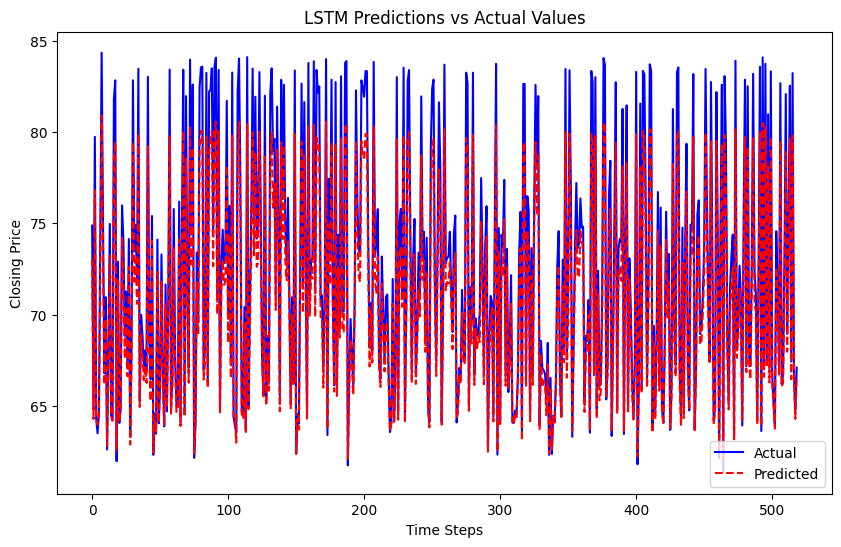

In [153]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

target = 'Closing_price'
features = [col for col in usdinr.columns if col not in ['Date', target]]

# Separate X and y
X = usdinr[features]
y = usdinr[target].values
X = X.select_dtypes('number').values

# Normalize X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Create sequences
sequence_length = 30

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        # Add sequences from X
        X_seq.append(X[i:i + sequence_length])
        # Add the corresponding target from y
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2)

# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, X_train.shape[2]), return_sequences=False),
    Dropout(0.2),  # Regularization
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train)
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
y_test_pred = model.predict(X_test)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

# Rescale actual test data for comparison
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual", color="blue")
plt.plot(y_test_pred_rescaled, label="Predicted", color="red", linestyle="--")
plt.legend()
plt.title("LSTM Predictions vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Closing Price")
plt.show()

Prophet

In [159]:
import plotly.graph_objects as go
from prophet import Prophet

# Load the data
# Ensure your dataset has columns like 'Date', 'Closing_price', 'RSI', 'MACD', etc.
ds = usdinr  # Replace `usdinr` with your actual dataframe variable
print("Columns in dataset:", ds.columns)

# Rename columns as Prophet requires 'ds' (date) and 'y' (target)
ds.rename(columns={'Date': 'ds', 'Closing_price': 'y'}, inplace=True)

# Drop missing values
ds.dropna(inplace=True)

# Specify the additional regressors
regressors = [
    'Deseasonalized_Day_high', 'Deseasonalized_Day_low',
    'Deseasonalized_Open_price', 'EMA_100', 'EMA_200', 'EMA_50', 'RSI',
    'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band', 'Lower Band'
]

# Ensure all specified regressors are present in the dataset
missing_regressors = [r for r in regressors if r not in df.columns]
if missing_regressors:
    raise ValueError(f"Missing regressors in dataset: {missing_regressors}")

# Initialize the Prophet model (with default parameters)
prophet_model = Prophet()

# Set the random state for reproducibility
prophet_model.random_state = 42

# Add each regressor to the Prophet model
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(ds))
train = ds[:train_size]
test = ds[train_size:]

# Train the model
prophet_model.fit(train[['ds', 'y'] + regressors])

# Create a future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test))
for regressor in regressors:
    future[regressor] = ds[regressor]

# Make predictions
forecast = prophet_model.predict(future)

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, mse, rmse, mape, accuracy

# Evaluate on train and test sets
train_forecast = prophet_model.predict(train[['ds'] + regressors])
train_yhat = train_forecast['yhat'].values
train_metrics = evaluate_model(train['y'].values, train_yhat)

test_forecast = prophet_model.predict(test[['ds'] + regressors])
test_yhat = test_forecast['yhat'].values
test_metrics = evaluate_model(test['y'].values, test_yhat)

# Print metrics
print("Train Metrics:")
print(f"MAE: {train_metrics[0]:.4f}, MSE: {train_metrics[1]:.4f}, RMSE: {train_metrics[2]:.4f}, MAPE: {train_metrics[3]:.2f}%, Accuracy: {train_metrics[4]:.2f}%")
print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}, MSE: {test_metrics[1]:.4f}, RMSE: {test_metrics[2]:.4f}, MAPE: {test_metrics[3]:.2f}%, Accuracy: {test_metrics[4]:.2f}%")

# Plot predictions vs actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual', line=dict(color='blue')))

# Plot predicted values
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicted', line=dict(color='red')))

# Plot upper and lower bounds
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Upper Bound',
    line=dict(color='lightgrey', dash='dot')
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Lower Bound',
    line=dict(color='lightgrey', dash='dot')
))

# Update layout
fig.update_layout(
    title="Prophet with Regressors: Predictions vs Actual",
    xaxis_title="Date",
    yaxis_title="Closing Price",
    legend_title="Legend",
    template="plotly_white"
)

fig.show()

Columns in dataset: Index(['ds', 'Open_price', 'Day_high', 'Day_low', 'y', 'Currency Pair',
       'Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_50', 'EMA_100', 'EMA_200', 'RSI',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band',
       'Lower Band', 'cap'],
      dtype='object')


22:43:01 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1] done processing


Train Metrics:
MAE: 0.0677, MSE: 0.0081, RMSE: 0.0899, MAPE: 0.10%, Accuracy: 99.90%

Test Metrics:
MAE: 0.2168, MSE: 0.0591, RMSE: 0.2430, MAPE: 0.26%, Accuracy: 99.74%


In [154]:
from prophet import Prophet

# Calculate MAE, MSE, RMSE, and MAPE for the train and test sets
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    accuracy = 100 - mape  # Accuracy-like score as (100% - MAPE)
    
    return mae, mse, rmse, mape, accuracy


# Load the data
df = usdinr  # Replace this with your data
df.rename(columns={'Date': 'ds', 'Closing_price': 'y'}, inplace=True)
df.dropna(inplace=True)

# Add the 'cap' column for logistic growth (set it to the max of 'y')
df['cap'] = df['y'].max()

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train = df[:train_size]
test = df[train_size:]

# Set up the hyperparameters grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1, 10, 20],
    'holidays_prior_scale': [10, 15, 20],
    'changepoint_range': [0.8, 0.9],
    'growth': ['linear', 'logistic']  # Will test both linear and logistic growth
}

# Initialize variables to store the best model and best score
best_model = None
best_score = float('inf')
best_params = {}

# Grid Search Loop
for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        for holidays_prior_scale in param_grid['holidays_prior_scale']:
            for changepoint_range in param_grid['changepoint_range']:
                for growth in param_grid['growth']:
                    # Initialize Prophet with the current set of hyperparameters
                    prophet_model = Prophet(
                        changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale,
                        holidays_prior_scale=holidays_prior_scale,
                        changepoint_range=changepoint_range,
                        growth=growth
                    )
                    
                    # If logistic growth, add the 'cap' column
                    if growth == 'logistic':
                        prophet_model.fit(train[['ds', 'y', 'cap','Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_100', 'EMA_200', 'EMA_50', 'RSI',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band',
       'Lower Band']])
                    else:
                        prophet_model.fit(train[['ds', 'y','Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_100', 'EMA_200', 'EMA_50', 'RSI',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band',
       'Lower Band']])
                    
                    # Create future dataframe for predictions
                    future = prophet_model.make_future_dataframe(periods=len(test))
                    
                    # Add the 'cap' column for logistic growth
                    if growth == 'logistic':
                        future['cap'] = df['cap'].iloc[0]  # Same constant value as for training
                    
                    forecast = prophet_model.predict(future)
                    
                    # Evaluate model performance on the test set
                    test_yhat = forecast['yhat'][-len(test):].values
                    mae, mse, rmse, mape, accuracy = evaluate_model(test['y'].values, test_yhat)
                    
                    # If the model has better performance, store it
                    if mse < best_score:
                        best_score = mse
                        best_model = prophet_model
                        best_params = {
                            'changepoint_prior_scale': changepoint_prior_scale,
                            'seasonality_prior_scale': seasonality_prior_scale,
                            'holidays_prior_scale': holidays_prior_scale,
                            'changepoint_range': changepoint_range,
                            'growth': growth
                        }

# Output the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best MSE:", best_score)

# Evaluate the best model on the test set
best_forecast = best_model.predict(best_model.make_future_dataframe(periods=len(test)))
test_yhat = best_forecast['yhat'][-len(test):].values
mae, mse, rmse, mape, accuracy = evaluate_model(test['y'].values, test_yhat)

print("Test Metrics for Best Model:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, Accuracy: {accuracy:.2f}%")


22:28:42 - cmdstanpy - INFO - Chain [1] start processing
22:28:42 - cmdstanpy - INFO - Chain [1] done processing
22:28:43 - cmdstanpy - INFO - Chain [1] start processing
22:28:43 - cmdstanpy - INFO - Chain [1] done processing
22:28:47 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing
22:28:48 - cmdstanpy - INFO - Chain [1] start processing
22:28:49 - cmdstanpy - INFO - Chain [1] done processing
22:28:53 - cmdstanpy - INFO - Chain [1] start processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing
22:28:54 - cmdstanpy - INFO - Chain [1] start processing
22:28:54 - cmdstanpy - INFO - Chain [1] done processing
22:28:58 - cmdstanpy - INFO - Chain [1] start processing
22:28:59 - cmdstanpy - INFO - Chain [1] done processing
22:28:59 - cmdstanpy - INFO - Chain [1] start processing
22:29:00 - cmdstanpy - INFO - Chain [1] done processing
22:29:04 - cmdstanpy - INFO - Chain [1] start processing
22:29:04 - cmdstanpy - INFO - Chain [1]

Best Hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20, 'holidays_prior_scale': 10, 'changepoint_range': 0.8, 'growth': 'linear'}
Best MSE: 2.635798380293926
Test Metrics for Best Model:
MAE: 1.3827, MSE: 2.6358, RMSE: 1.6235, MAPE: 1.66%, Accuracy: 98.34%


In [157]:
import plotly.graph_objects as go
# Load the data
# Ensure your dataset has columns like 'Date', 'Closing_price', 'RSI', 'MACD', etc.
df = usdinr  # Replace `jpy_inr` with your actual dataframe variable
print("Columns in dataset:", df.columns)

# Rename columns as Prophet requires 'ds' (date) and 'y' (target)
df.rename(columns={'Date': 'ds', 'Closing_price': 'y'}, inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Specify the additional regressors
regressors = [
    'Deseasonalized_Day_high', 'Deseasonalized_Day_low',
    'Deseasonalized_Open_price', 'EMA_100', 'EMA_200', 'EMA_50', 'RSI',
    'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band', 'Lower Band'
]

# Ensure all specified regressors are present in the dataset
missing_regressors = [r for r in regressors if r not in df.columns]
if missing_regressors:
    raise ValueError(f"Missing regressors in dataset: {missing_regressors}")

# Initialize the Prophet model with tuned hyperparameters
prophet_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    growth=best_params['growth']
)

# Set the random state for reproducibility
prophet_model.random_state = 42

# Add each regressor to the Prophet model
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(df))
train = df[:train_size]
test = df[train_size:]


# Train the model
#best_model.fit(train[['ds', 'y'] + regressors ])

# Create a future dataframe for predictions
future = best_model.make_future_dataframe(periods=len(test))
for regressor in regressors:
    future[regressor] = df[regressor]



# Make predictions
forecast = best_model.predict(future)

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, mse, rmse, mape, accuracy

# Evaluate on train and test sets
train_forecast = best_model.predict(train[['ds'] + regressors ])
train_yhat = train_forecast['yhat'].values
train_metrics = evaluate_model(train['y'].values, train_yhat)

test_forecast = best_model.predict(test[['ds'] + regressors ])
test_yhat = test_forecast['yhat'].values
test_metrics = evaluate_model(test['y'].values, test_yhat)

# Print metrics
print("Train Metrics:")
print(f"MAE: {train_metrics[0]:.4f}, MSE: {train_metrics[1]:.4f}, RMSE: {train_metrics[2]:.4f}, MAPE: {train_metrics[3]:.2f}%, Accuracy: {train_metrics[4]:.2f}%")
print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}, MSE: {test_metrics[1]:.4f}, RMSE: {test_metrics[2]:.4f}, MAPE: {test_metrics[3]:.2f}%, Accuracy: {test_metrics[4]:.2f}%")

# Plot predictions vs actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Actual', line=dict(color='blue')))

# Plot predicted values
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Predicted', line=dict(color='red')))

# Plot upper and lower bounds
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Upper Bound',
    line=dict(color='lightgrey', dash='dot')
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Lower Bound',
    line=dict(color='lightgrey', dash='dot')
))

# Update layout
fig.update_layout(
    title="Prophet with Regressors: Predictions vs Actual",
    xaxis_title="Date",
    yaxis_title="Closing Price",
    legend_title="Legend",
    template="plotly_white"
)

fig.show()

Columns in dataset: Index(['ds', 'Open_price', 'Day_high', 'Day_low', 'y', 'Currency Pair',
       'Deseasonalized_Day_high', 'Deseasonalized_Day_low',
       'Deseasonalized_Open_price', 'EMA_50', 'EMA_100', 'EMA_200', 'RSI',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA', 'Upper Band',
       'Lower Band', 'cap'],
      dtype='object')
Train Metrics:
MAE: 0.7176, MSE: 0.8271, RMSE: 0.9094, MAPE: 1.02%, Accuracy: 98.98%

Test Metrics:
MAE: 2.6181, MSE: 9.9436, RMSE: 3.1533, MAPE: 3.14%, Accuracy: 96.86%


CNN

In [161]:
usdinr

ds  Open_price  Day_high  Day_low       y Currency Pair  \
0    2014-11-07      61.390   61.6200   61.340  61.400       USD/INR   
1    2014-11-10      61.500   61.6350   61.340  61.495       USD/INR   
2    2014-11-11      61.530   61.5550   61.505  61.508       USD/INR   
3    2014-11-12      61.508   61.5600   61.350  61.391       USD/INR   
4    2014-11-13      61.368   61.6230   61.350  61.565       USD/INR   
...         ...         ...       ...      ...     ...           ...   
2616 2024-11-19      84.376   84.4300   84.333  84.335       USD/INR   
2617 2024-11-20      84.369   84.3840   84.301  84.340       USD/INR   
2618 2024-11-21      84.342   84.5200   84.342  84.475       USD/INR   
2619 2024-11-22      84.475   84.5025   84.354  84.405       USD/INR   
2620 2024-11-25      84.405   84.4450   84.232  84.260       USD/INR   

      Deseasonalized_Day_high  Deseasonalized_Day_low  \
0                   61.610178               61.342069   
1                   61.627417               61.332354   
2                   61.547782               61.499583   
3                   61.567062               61.356291   
4                   61.633828               61.348395   
...                       ...                     ...   
2616                84.432802               84.336238   
2617                84.387932               84.304071   
2618                84.510178               84.344069   
2619                84.494917               84.346354   
2620                84.437782               84.226583   

      Deseasonalized_Open_price     EMA_50    EMA_100    EMA_200        RSI  \
0                     61.393685  61.400000  61.400000  61.400000   0.000000   
1                     61.493849  61.403725  61.401881  61.400945   0.000000   
2                     61.516470  61.407815  61.403983  61.402010   0.000000   
3                     61.503613  61.407155  61.403725  61.401901   0.000000   
4                     61.385107  61.413345  61.406919  61.403524   0.000000   
...                         ...        ...        ...        ...        ...   
2616                  84.376023  84.066797  83.892191  83.624050  68.974700   
2617                  84.372253  84.077511  83.901059  83.631173  70.390310   
2618                  84.345685  84.093098  83.912424  83.639570  74.943052   
2619                  84.468849  84.105330  83.922178  83.647186  68.512486   
2620                  84.391470  84.111395  83.928867  83.653284  58.767773   

          MACD  Signal_Line  MACD_Histogram       SMA  Upper Band  Lower Band  \
0     0.000000     0.000000        0.000000  61.74960   62.164424   61.334776   
1     0.007578     0.001516        0.006063  61.74960   62.164424   61.334776   
2     0.014466     0.004106        0.010361  61.74960   62.164424   61.334776   
3     0.010365     0.005358        0.005007  61.74960   62.164424   61.334776   
4     0.020914     0.008469        0.012445  61.74960   62.164424   61.334776   
...        ...          ...             ...       ...         ...         ...   
2616  0.114484     0.106667        0.007816  84.20835   84.524657   83.892043   
2617  0.108542     0.107042        0.001500  84.22350   84.534227   83.912773   
2618  0.113419     0.108318        0.005101  84.24405   84.564571   83.923529   
2619  0.110363     0.108727        0.001636  84.26055   84.578394   83.942706   
2620  0.095144     0.106010       -0.010866  84.27155   84.572008   83.971092   

         cap  
0     84.475  
1     84.475  
2     84.475  
3     84.475  
4     84.475  
...      ...  
2616  84.475  
2617  84.475  
2618  84.475  
2619  84.475  
2620  84.475  

[2621 rows x 20 columns]

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0611 - mae: 0.1639 - val_loss: 0.0018 - val_mae: 0.0323
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mae: 0.0545 - val_loss: 0.0016 - val_mae: 0.0326
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 0.0469 - val_loss: 0.0018 - val_mae: 0.0334
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0419 - val_loss: 8.9466e-04 - val_mae: 0.0228
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0377 - val_loss: 7.8719e-04 - val_mae: 0.0213
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0010 - val_mae: 0.0260
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0368 - val_loss: 5.5462e-04 - val_mae: 0.0176
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0323 - val_loss: 5.4924e-04 - val_mae: 0.0177
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

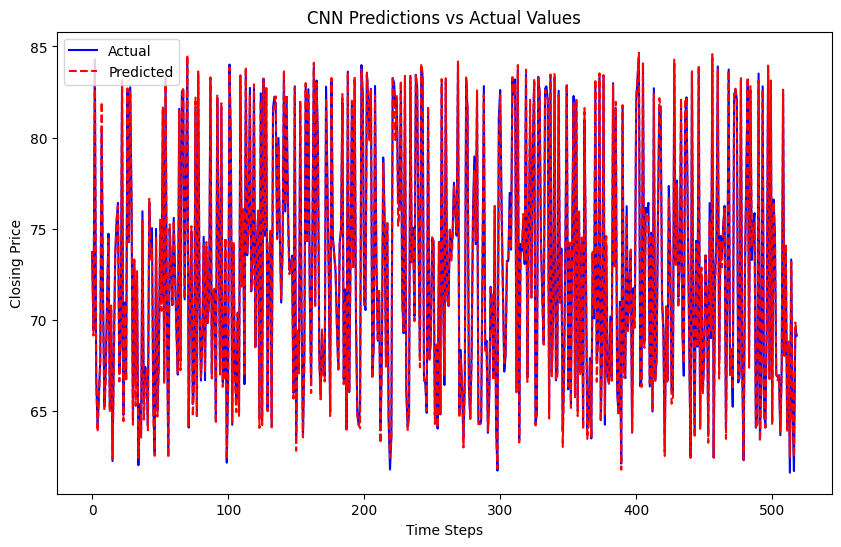

In [162]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define features (X) and target (y)
target = 'y'  # Change to your target column
features = [col for col in usdinr.columns if col not in ['ds', target]]

# Separate X and y
X = usdinr[features]
y = usdinr[target].values
X = X.select_dtypes('number').values

# Normalize X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Create sequences
sequence_length = 30

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build CNN model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    MaxPooling1D(2),
    Dropout(0.2),  # Regularization
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
train_loss, train_mae = cnn_model.evaluate(X_train, y_train)
test_loss, test_mae = cnn_model.evaluate(X_test, y_test)

print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_rescaled = scaler_y.inverse_transform(y_pred_cnn.reshape(-1, 1))

# Rescale actual test data for comparison
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual", color="blue")
plt.plot(y_pred_cnn_rescaled, label="Predicted", color="red", linestyle="--")
plt.legend()
plt.title("CNN Predictions vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Closing Price")
plt.show()
